# Heart Disease Predictions


### Diego Berny and Anna Griffin

Data Science 2019 | Allen Downey <br />
[MIT License](https://mit-license.org/)

Using a model, how accurately can we predict the presence of heart disease? Since heart disease is the most common cause of death in the United States, this is a pressing question. Leveraging our machine learning tools  and the data from the Cleveland Heart Disease Database, we explored a variety of models to evaluate how we are able to get. 

## The data

First we import the following libraries. Using pandas, we read our data from the csv files provided by Driven Data. The database is open to the public and contains health records and cardiovascular statistics from anonymous patients. Our target variable is `'heart_disease_present'`. This information is encoded as either a 1 (present) or a 0 (not present).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier


#### Helper Functions

In [2]:
# separate target and features, get dummy data for categorical data
def preprocess(train_values, train_labels, target, dummies=True):
    X = train_values[train_values.columns[1:]]
    y = train_labels[target]
    
    if dummies == True:
        X = pd.get_dummies(X, drop_first=True)
    
    return X, y

In [3]:
# split data into test and training sets
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
    
    
    return X_train, X_test, y_train, y_test

In [4]:
# train and evaluate classifier
def train_score(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    score = clf.score(X_test, y_test)
        
    print("Coefficient of Determination: ", score)


In [5]:
def plot_roc(clf, X_test, y_test):
    y_pred_prob =clf.predict_proba(X_test)[:,1]
    fpr, tpr, threasholds = roc_curve(y_test, y_pred_prob)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    return y_pred_prob

## Logistic Regression

We start with logistic regression as a baseline. 

In [7]:
train_values = pd.read_csv("../train_values.csv")
train_labels = pd.read_csv("../train_labels.csv")

In [8]:
X, y = preprocess(train_values, train_labels, 'heart_disease_present')
X_train, X_test, y_train, y_test = split(X,y)

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# baseline Log regression
logreg = LogisticRegression()
train_score(logreg, X_train, X_test, y_train, y_test)

Coefficient of Determination:  0.8333333333333334


After fitting our training set to the Logistic Regression model, we asses its accuracy by finding the fraction of predictions that were correct. In this case, our coefficient of determination is 0.8334.

In [12]:
predictions = logreg.predict(X_test)
scores = cross_val_score(logreg, X, y, cv=5)

This ROC curve plots the false positive rate against the true positive rate. The area under this curve measures the accuracy of our model. Ideally, the area would equal 1, however that is rarely the case. The area under this curve is 0.889 using the 5 fold cross-calidation method.

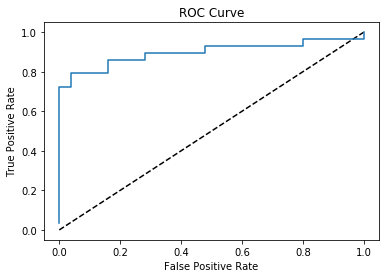

In [13]:
y_pred_prob = plot_roc(logreg, X_test, y_test)

In [14]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg, X,y,cv=5,scoring='roc_auc')
print("Average AUC score using 5-fold: ", np.mean(cv_auc))


AUC: 0.8979310344827587
Average AUC score using 5-fold:  0.889375


While still keeping this score in mind, there are other classifiers that could provide more accurate predictions. This was just our baseline. We can now experiment with other classifiers to see if we can improve this score.

## K-Nearest Neighboors

The K-nearest neighboors approach that looks that the neighboors of the data point in the set. Depending on the number of neighbors that is specified, each data point will be classified based on its relative position to nearby data points. 

In [16]:
train_values = pd.read_csv("../train_values.csv")
train_labels = pd.read_csv("../train_labels.csv")

X, y = preprocess(train_values, train_labels, 'heart_disease_present')
X_train, X_test, y_train, y_test = split(X,y)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
knn = KNeighborsClassifier(n_neighbors=4)
train_score(knn, X_train, X_test, y_train, y_test)

Coefficient of Determination:  0.7962962962962963


A score of 0.796 is less than our baseline score. However, we arbitrary set `n_neighbors` to 4. Maybe a different number of neighbors would better suit this data. In order to find the best number, we can create a graph of accuracies with varying neighbors. 

In [18]:
neighbors = np.arange(1,10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    
    test_accuracy[i] = knn.score(X_test, y_test)

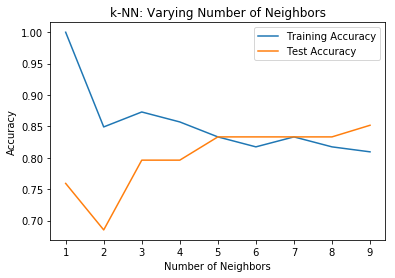

In [19]:
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.plot(neighbors, test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Coefficient of Determination:  0.8333333333333334


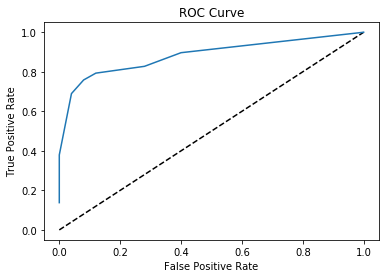

AUC: 0.883448275862069
Average AUC score using 5-fold:  0.6125


In [20]:
knn = KNeighborsClassifier(n_neighbors=7)
train_score(knn, X_train, X_test, y_train, y_test)

y_pred_prob = plot_roc(knn, X_test, y_test)

print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(knn, X,y,cv=5,scoring='roc_auc')
print("Average AUC score using 5-fold: ", np.mean(cv_auc))

Based on the graph, a model that looks at the 7 closest neighbors will perform better than our original that looked at 4. However, the KNNeighbor classifier did not out preform the baseline logistic regression classifier. 

## Random Forest

The random forest classifier uses decision trees from the training set to make a decision on the result of the prediction. This method analyzes the results for the different decision treese to make the final classification decision.

In [21]:
train_values = pd.read_csv("../train_values.csv")
train_labels = pd.read_csv("../train_labels.csv")

X, y = preprocess(train_values, train_labels, 'heart_disease_present')
X_train, X_test, y_train, y_test = split(X,y)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42, verbose = 1, n_jobs=-1)
train_score(random_forest, X_train, X_test, y_train, y_test)

Coefficient of Determination:  0.8333333333333334


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [24]:
predictions = random_forest.predict(X_test)
scores = cross_val_score(random_forest, X, y, cv=5)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


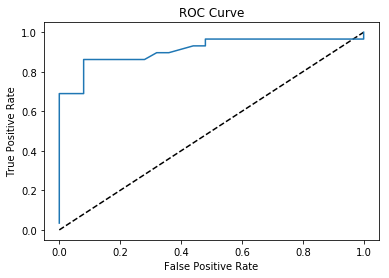

In [25]:
y_pred_prob = plot_roc(random_forest, X_test, y_test)

In [26]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(random_forest, X,y,cv=5,scoring='roc_auc')
print("Average AUC score using 5-fold: ", np.mean(cv_auc))

AUC: 0.9110344827586206


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jo

Average AUC score using 5-fold:  0.8881249999999999


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


This score seems pretty comparable to our baseline score. This classifier did not improve our prediction very much but it performed well in comparison to our baseline.

## Feature Importances

In addition to fitting different classifiers to our data, we can also analyze the data to optimize the training. The `.feature_importances_` method calculates a value for each feature to express its importance. This makes it easy to compare features so that we can get rid of potentially unnecessary features that are slowing the process down.

Feature ranking:
1. (0.128203)    oldpeak_eq_st_depression 
2. (0.118240)    max_heart_rate_achieved 
3. (0.093594)    thal_reversible_defect 
4. (0.088744)    num_major_vessels 
5. (0.086874)    serum_cholesterol_mg_per_dl 
6. (0.081501)    age 
7. (0.075099)    chest_pain_type 
8. (0.072313)    thal_normal 
9. (0.070806)    slope_of_peak_exercise_st_segment 
10. (0.066576)    exercise_induced_angina 
11. (0.066398)    resting_blood_pressure 
12. (0.025117)    resting_ekg_results 
13. (0.016317)    sex 
14. (0.010218)    fasting_blood_sugar_gt_120_mg_per_dl 


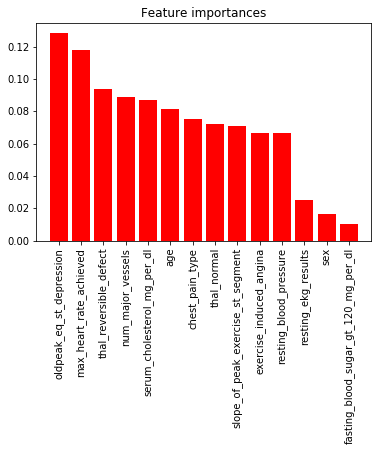

In [27]:
features = list(X.columns)
importances = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
lables = []

for each in indices:
    lables.append(feature_importances['feature'].iloc[each])
    

for f in range(X_train.shape[1]):
    print("%d. (%f)    %s " % (f + 1, importances[indices[f]],  lables[f]))    
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]),lables, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The last three features on the right of the graph are noticible less than the features to their left. Removing these features could potentially improve our model. 

In [29]:
train_values = pd.read_csv("../train_values.csv")
train_labels = pd.read_csv("../train_labels.csv")

X, y = preprocess(train_values, train_labels, 'heart_disease_present')
X_train, X_test, y_train, y_test = split(X,y)

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
X, y = preprocess(train_values, train_labels, 'heart_disease_present')

X = X.drop(columns=['fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'resting_ekg_results'])
X.shape

(180, 11)

In [31]:
X_train, X_test, y_train, y_test = split(X,y)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [32]:
logreg = LogisticRegression()
train_score(logreg, X_train, X_test, y_train, y_test)

Coefficient of Determination:  0.8518518518518519


In [33]:
predictions = logreg.predict(X_test)
scores = cross_val_score(logreg, X, y, cv=5)

cm = confusion_matrix(y_test, predictions)

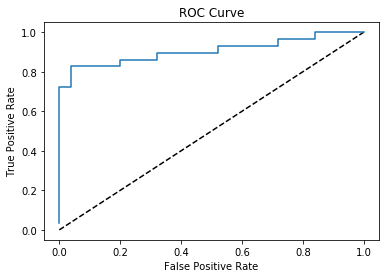

In [34]:
y_pred_prob = plot_roc(logreg, X_test, y_test)

In [35]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg, X,y,cv=5,scoring='roc_auc')
print("Average AUC score using 5-fold: ", np.mean(cv_auc))

AUC: 0.906206896551724
Average AUC score using 5-fold:  0.88375


The area under the curve for this model is almost the same as our base line. 

## Binning Data

There are a some feaatures that are represented by numerical data. Binning this data can help eliminate noise within these groups.

In [37]:
train_values = pd.read_csv("../train_values.csv")
train_labels = pd.read_csv("../train_labels.csv")

X, y = preprocess(train_values, train_labels, 'heart_disease_present')

X = X.drop(columns=['fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'resting_ekg_results'])
X.shape

(180, 11)

In [38]:
X['CatAge'] = pd.qcut(X.age, q=4, labels=False)
X['Catrbp'] = pd.qcut(X['resting_blood_pressure'], q=8, labels=False)
X['CatSerum'] = pd.qcut(X['serum_cholesterol_mg_per_dl'], q=4, labels=False)
X['CatMaxhr'] = pd.qcut(X['max_heart_rate_achieved'], q=4, labels=False)

In [39]:
X = X.drop(['age','resting_blood_pressure','serum_cholesterol_mg_per_dl', 'max_heart_rate_achieved'], axis=1)
X.shape

(180, 11)

In [40]:
X_train, X_test, y_train, y_test = split(X,y)


scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
logreg = LogisticRegression()
train_score(logreg, X_train, X_test, y_train, y_test)

Coefficient of Determination:  0.8518518518518519


In [42]:
predictions = logreg.predict(X_test)
scores = cross_val_score(logreg, X, y, cv=5)

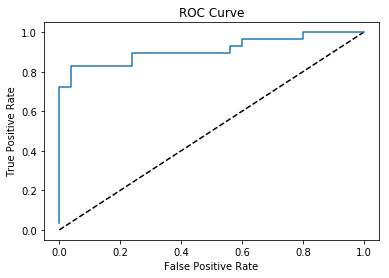

In [43]:
y_pred_prob = plot_roc(logreg, X_test, y_test)

In [44]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg, X,y,cv=5,scoring='roc_auc')
print("Average AUC score using 5-fold: ", np.mean(cv_auc))

AUC: 0.9117241379310345
Average AUC score using 5-fold:  0.8731249999999999


## Conclusion

Overall our baseline logistic regression produced the best results. The other classifiers that we tried and the feature enginnering that we applied did not exceed our AUC score of our original logistic regression model. Our next set is to experiment with breaking down different features to see if we can reveal any hidden patterns in the data that will improve our training model. 